In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from DataLoaders import DataLoaders
import numpy as np
import torchvision

import matplotlib.pyplot as plt
import time
from pathlib import Path
from tqdm.notebook import trange, tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import itertools
# import pixiedust
import random
from torch.utils import data
from itertools import tee
from datetime import datetime
from utils import GradientReversal
from enum import Enum

print(torch.__version__)
torch.cuda.is_available()

1.5.0


True

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    LABS_DIR = Path ('/content/gdrive/My Drive/Labs')
except:
    LABS_DIR = Path ('C:/Labs/')

#DATA_DIR = LABS_DIR/'Data'    
DATA_DIR = LABS_DIR/'DataNoDuplicates'
DATA_DIR_M = LABS_DIR/'DataTraining'/'Male'
DATA_DIR_F = LABS_DIR/'DataTraining'/'Female'


In [4]:
class TrainingParams:
    def __init__(self, experiment_name, model,  lr_initial, weight_decay,step_size,gamma,num_epochs):
        self.experiment_name = experiment_name
        self.model = model
        self.label_criterion = nn.CrossEntropyLoss()  # softmax+log
        self.domain_criterion = nn.functional.binary_cross_entropy_with_logits # TODO check this loss criterion
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr_initial, weight_decay=weight_decay)
        self.scheduler= lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        self.num_epochs = num_epochs

In [5]:
#### sanity check for the images 
# classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
# for emotion in classes:
#     print("Class =",emotion)
#     !ls $DATA_DIR\VAL\$emotion | wc -l

# Data Loader

In [6]:
BATCH_SIZE = 16
# SAMPLE_SIZE = None 
SAMPLE_SIZE = None

dataloder_male = DataLoaders(sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE//2, data_dir=DATA_DIR_M, val_same_as_train=False)
dataloder_female = DataLoaders(sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE//2, data_dir=DATA_DIR_F, val_same_as_train=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Classes: ", dataloder_male.classes) 
print(f'Male Train image size: {dataloder_male.dataset_size["train"]}')
print(f'Male Validation image size: {dataloder_male.dataset_size["val"]}')
print(f'Female Train image size: {dataloder_female.dataset_size["train"]}')
print(f'Female Validation image size: {dataloder_female.dataset_size["val"]}')

Classes:  ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
Male Train image size: 1181
Male Validation image size: 299
Female Train image size: 1291
Female Validation image size: 326


In [7]:
class NET_ARCHICECTURE(Enum):
    NO_FC = 0
    ONE_FC = 1
    TWO_FC = 2

In [8]:
def get_model(class_names, architecure : NET_ARCHICECTURE):
    model_conv = models.resnet18(pretrained=True)
    #model_conv = models.resnet50(pretrained=True)
    #model_conv = models.resnet101(pretrained=True)    
    
    DROPOUT_PROB = 0.5
    
    num_ftrs = model_conv.fc.in_features #The size of feature extractor output

    if architecure == NET_ARCHICECTURE.NO_FC:
        new_lin = nn.Linear(num_ftrs, len(class_names))
    elif architecure == NET_ARCHICECTURE.ONE_FC:
        new_lin = nn.Sequential(
            nn.Linear(num_ftrs, 64),
            nn.ReLU(),
            nn.Dropout(DROPOUT_PROB),
            nn.Linear(64, len(class_names))
        )
    elif architecure == NET_ARCHICECTURE.TWO_FC:
        new_lin = nn.Sequential(
            nn.Linear(num_ftrs, 50),
            nn.ReLU(),
            nn.Dropout(DROPOUT_PROB),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Dropout(DROPOUT_PROB),
            nn.Linear(20, len(class_names))
        )
    else:
        raise Exception(f"Value {architecure} illegal")
        
    model_conv.fc = new_lin

    model_conv.avgpool.activation = {}
    def get_activation(name):
        def hook(model, input, output):
            model.activation[name] = output #.detach()
        return hook

    model_conv.avgpool.register_forward_hook(get_activation('avgpool'))
    
    model_conv.discriminator = nn.Sequential(
        GradientReversal(),
        nn.Linear(num_ftrs, 50),
        nn.ReLU(),
        nn.Linear(50, 20),
        nn.ReLU(),
        nn.Linear(20, 1)
    ).to(device)
    
    model_conv = model_conv.to(device)
    return model_conv

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated  


# Show sample of the data for review


classes=tensor([0, 2, 5, 1, 0, 3, 0, 5])


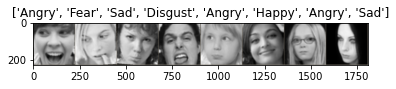

classes=tensor([0, 4, 1, 3, 2, 1, 0, 2])


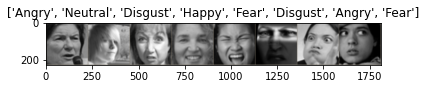

In [10]:
# # Get a batch of training data
class_names = dataloder_female.classes

inputs, classes = next(iter(dataloder_female.data['train']))
print()
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])


# # Get a batch of validation data
inputs, classes = next(iter(dataloder_female.data['val']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])

In [11]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
#     acc = torch.round(acc * 100)
    
    return acc

In [12]:
def train_model(males_dataloader, females_dataloader, training_params, writer=None):
    since = time.time()

    print("Starting epochs")
    for epoch in range(1, training_params.num_epochs + 1):
        print(f'Epoch: {epoch} of {training_params.num_epochs}')
        training_params.model.train()  # Set model to training mode
        running_corrects = 0.0
        running_corrects_domain = 0.0
        
        join_dataloader = zip(males_dataloader.data['train'], females_dataloader.data['train'])  # TODO check how females_data is built
        for i, ((males_x, males_label), (females_x, _)) in enumerate(join_dataloader):
            # data['train'] contains (males_x, males_y) for every batch (so i=[1...NUM OF BATCHES]
            samples = torch.cat([males_x, females_x])
            samples = samples.to(device)
            label_y = males_label.to(device)
            domain_y = torch.cat([torch.ones(males_x.shape[0]), torch.zeros(females_x.shape[0])])
            domain_y = domain_y.to(device)

            # zero the parameter gradients
            training_params.optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
#                 label_preds = training_params.model(samples[:males_x.shape[0]])  # TODO check if x[:males_x.shape[0]] = males_x
                label_preds = training_params.model(samples)[:males_x.shape[0]]  # TODO check if x[:males_x.shape[0]] = males_x
                label_loss = training_params.label_criterion(label_preds, label_y)

                # TODO check the discriminator
                extracted_features = training_params.model.avgpool.activation['avgpool']  # Size: torch.Size([16, 512, 1, 1])
                extracted_features = extracted_features.view(extracted_features.shape[0], -1)
                domain_preds = training_params.model.discriminator(extracted_features).squeeze()
                domain_loss = training_params.domain_criterion(domain_preds, domain_y)
                
                loss = label_loss+domain_loss
                # backward + optimize only if in training phase
                loss.backward()
                training_params.optimizer.step()

            batch_loss = loss.item() * samples.size(0)
            running_corrects += torch.sum(label_preds.max(1)[1] == label_y.data)
            running_corrects_domain += binary_acc(domain_preds, domain_y.data)
            

            if writer is not None:  # save train label_loss for each batch
                x_axis = 1000 * (epoch + i / (males_dataloader.dataset_size['train'] // BATCH_SIZE))#TODO devidie by batch size or batch size//2?
                writer.add_scalar('batch label_loss', batch_loss / BATCH_SIZE, x_axis)

        if training_params.scheduler is not None:
            training_params.scheduler.step()  # scheduler step is performed per-epoch in the training phase

        train_acc = running_corrects / males_dataloader.dataset_size['train'] # TODO change the accuracy ratio by the relevant dataset
        train_acc_domain = running_corrects_domain / i # avg accuracy per epoch (i= num. of batches)

        epoch_loss, epoch_acc = eval_model(males_dataloader, training_params)

        if writer is not None:  # save epoch accuracy
            x_axis = epoch
            writer.add_scalar('accuracy-train', train_acc, x_axis)
            writer.add_scalar('accuracy-val', epoch_acc, x_axis)
            writer.add_scalar('accuracy-train-discriminator', train_acc_domain, x_axis)
            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # return the last trained model
    return training_params

def eval_model(dataloader, training_params):
    training_params.model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(dataloader.data['val']):
        # data['val'] contains (input,labels) for every batch (so i=[1...NUM OF BATCHES]

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        training_params.optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = training_params.model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = training_params.label_criterion(outputs, labels)

        # statistics - sum loss and accuracy on all batches
        running_loss += loss.item() * inputs.size(0)  # item.loss() is the average loss of the batch
        running_corrects += torch.sum(outputs.max(1)[1] == labels.data)

    epoch_loss = running_loss / dataloader.dataset_size['val'] 
    epoch_acc = running_corrects.double() / dataloader.dataset_size['val'] 
    print(f'Test Loss: {epoch_loss:.4f} TestAcc: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc

In [13]:
#model_conv.eval()

# Train Model

In [14]:
# CHECK_POINT_PATH = LABS_DIR/'ModelParams'/'checkpoint.tar'

# # !del $CHECK_POINT_PATH

# try:
#     checkpoint = torch.load(CHECK_POINT_PATH)
#     print("checkpoint loaded")
# except:
#     checkpoint = None
#     print("checkpoint not found")

In [15]:
# model_conv.eval()
def test(dataloader,training_params):
    epoch_loss, epoch_acc = eval_model(dataloader, training_params)
    print(f'Test accuracy: {epoch_acc:.4f}')
    

In [16]:
#### Tensorboard Stuff
NUM_EPOCHS = 30

def run_experiment(dropout_layer : NET_ARCHICECTURE, data_m,data_f, lr_initial, gamma, step_size, weight_decay, num_of_epochs, experiment_note=""):
    """
    Gets all hyper parameters and creates the relevant optimizer and scheduler according to those params

    """
    experiment_name = datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + experiment_note + f'_{dropout_layer.name}_lr_{lr_initial}_st_{step_size}_gma_{gamma}_wDK_{weight_decay}'
    training_params = TrainingParams(experiment_name , get_model(data_m.classes, dropout_layer), lr_initial, weight_decay, step_size, gamma, num_of_epochs)

    print("Starting, experiment name: ", experiment_name)

    writer = SummaryWriter('runs/' + experiment_name)
    trained_params_model = train_model(data_m, data_f, training_params, writer=writer)
    
    print("Experiment {experiment_name} - testing on the women domain")
    test(data_f,trained_params_model)
    print("Finished -----------------\r\n\r\n")
    return trained_params_model


# for lr in [0.001, 0.0005, 0.0001]:
#     for scheduler_step_size in [7]:
#         for scheduler_gamma in [0.3, 0.5]:
#             for weight_decay in [0.01,0.05,0.1]:
#                 model_conv = run_experiment(dataloder_male,dataloder_female, lr, scheduler_gamma, scheduler_step_size, weight_decay, NUM_EPOCHS,'fc_20+50_DO')


# trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.TWO_FC, data_m=dataloder_male,data_f=dataloder_female, lr_initial=0.0001, gamma=0.5, step_size=7, weight_decay=0.01 , num_of_epochs=10,experiment_note='final_tuning')

trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.TWO_FC, data_m=dataloder_male,data_f=dataloder_female, lr_initial=0.0001, gamma=0.5, step_size=7, weight_decay=0.01 , num_of_epochs=NUM_EPOCHS,experiment_note='final_tuning')
trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.NO_FC, data_m=dataloder_male,data_f=dataloder_female, lr_initial=0.0001, gamma=0.5, step_size=7, weight_decay=0.1, num_of_epochs=NUM_EPOCHS,experiment_note='final_tuning')
trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.ONE_FC, data_m=dataloder_male,data_f=dataloder_female, lr_initial=0.0001, gamma=0.5, step_size=7, weight_decay=0.1, num_of_epochs=NUM_EPOCHS,experiment_note='final_tuning')
trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.NO_FC, data_m=dataloder_male,data_f=dataloder_female, lr_initial=0.0001, gamma=0.3, step_size=7, weight_decay=0.1, num_of_epochs=NUM_EPOCHS,experiment_note='final_tuning')

# trained_model_and_params = run_experiment(NET_ARCHICECTURE.NO_FC, dataloder_male,dataloder_female, lr, scheduler_gamma, scheduler_step_size, weight_decay, NUM_EPOCHS,'final_tuning')


Starting, experiment name:  20200823-135052_final_tuning_TWO_FC_lr_0.0001_st_7_gma_0.5_wDK_0.01
Starting epochs
Epoch: 1 of 30
Test Loss: 1.9021 TestAcc: 0.2040
Epoch: 2 of 30
Test Loss: 1.7966 TestAcc: 0.2943
Epoch: 3 of 30
Test Loss: 1.8236 TestAcc: 0.2709
Epoch: 4 of 30
Test Loss: 1.7148 TestAcc: 0.3913
Epoch: 5 of 30
Test Loss: 1.6880 TestAcc: 0.3779
Epoch: 6 of 30
Test Loss: 1.6737 TestAcc: 0.4515
Epoch: 7 of 30
Test Loss: 1.6502 TestAcc: 0.3846
Epoch: 8 of 30
Test Loss: 1.5449 TestAcc: 0.4849
Epoch: 9 of 30
Test Loss: 1.6041 TestAcc: 0.4314
Epoch: 10 of 30
Test Loss: 1.5690 TestAcc: 0.4482
Epoch: 11 of 30
Test Loss: 1.5933 TestAcc: 0.4582
Epoch: 12 of 30
Test Loss: 1.5782 TestAcc: 0.4314
Epoch: 13 of 30
Test Loss: 1.5732 TestAcc: 0.4548
Epoch: 14 of 30
Test Loss: 1.6514 TestAcc: 0.4181
Epoch: 15 of 30
Test Loss: 1.5555 TestAcc: 0.4314
Epoch: 16 of 30
Test Loss: 1.5944 TestAcc: 0.4515
Epoch: 17 of 30
Test Loss: 1.5985 TestAcc: 0.4649
Epoch: 18 of 30
Test Loss: 1.5679 TestAcc: 0.45

In [17]:
# torch.save({'model_state_dict': model_conv.state_dict(),
#             'optimizer_state_dict': optimizer_conv.state_dict(),
#             'best_val_loss': best_val_loss,
#             'best_val_accuracy': best_val_acc,
#             'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
#             }, CHECK_POINT_PATH)

In [ ]:
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

# Test Model